In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import feather
from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Analyze the data

In [12]:
books = feather.read_dataframe('./feather/books')
ratings = pd.read_csv('./data/ratings.csv')
print('Number of books:', len(books.book_id.unique()))
print('Number of users:', len(ratings.user_id.unique()))

Number of books: 10000
Number of users: 53424


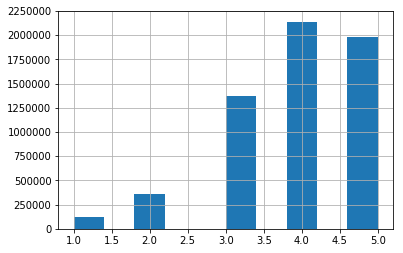

In [13]:
# Ratings distribution
ratings.rating.hist()

From the graph, we can see that the dataset contains mostly 4 and 5 ratings (as expected, since the dataset only contains ratings on popular books)

Normally, we would consider an item rated at 4 and 5 as a "hit" (or observation), since it's sufficient enough to recommend 4-rating books to users. However, in this case, since the number of 4 and 5 ratings take up 2/3 of the whole ratings, it might be a better idea to use 5-rating only as an observation.

We will split the ratings into a training set and a testing set. The testing set will only contain only 5-rating (we consider all other recommendation less than 5 as inferior). The proportion of 5-ratings we will take away from each user is 1/3, so it's better if we leave out users who have less than 3 5-rating.

It is also worth noting that we won't need a separate validation set and testing set since we will not be optimizing/tuning our models. The goal of the project at of right now is to merely inspect the qualities of different types of recommender systems and not finding the recommender system with the best performance. Optimizing will be left to later phases, most likely when building the web application.

In [6]:
# Only 5 ratings
only_five_ratings = ratings[ratings.rating==5]
only_five_ratings.shape

(1983093, 3)

In [7]:
# Count how many 5-rating each user has
five_ratings_for_each_user = only_five_ratings.groupby('user_id').rating.count()
(five_ratings_for_each_user > 2).sum()

52363

52363 users out of 53424 users have more than 3 5-rating. We will leave out those who don't have enough 5-rating required.

In [14]:
kept_users = five_ratings_for_each_user[five_ratings_for_each_user > 2].index.tolist()
print('Kept users:', len(kept_users))
kept_ratings = ratings[ratings.user_id.isin(kept_users)]
print('Kept ratings:', len(kept_ratings))

Kept users: 52363
Kept ratings: 5867414


Then we'll save the kept ratings for later use

In [18]:
kept_ratings.reset_index(drop=True).to_feather('./feather/ratings')

# 2. Split the data

In [19]:
kept_4_and_less_ratings = kept_ratings[kept_ratings.rating<5]
kept_5_ratings = kept_ratings[kept_ratings.rating==5]
(kept_4_and_less_ratings.shape, kept_5_ratings.shape)

((3885446, 3), (1981968, 3))

In [20]:
training_5_ratings, testing_ratings = train_test_split(kept_5_ratings, 
                                                       test_size=1/3, 
                                                       random_state=42, 
                                                       stratify=kept_5_ratings[['user_id']])
(training_5_ratings.shape, testing_ratings.shape)

((1321312, 3), (660656, 3))

In [21]:
print('Number of users in testing set:', len(testing_ratings.user_id.unique()))
print('Number of users in training set:', len(training_5_ratings.user_id.unique()))

Number of users in testing set: 52363
Number of users in training set: 52363


Let's check out some users to see if we split correctly

In [22]:
kept_5_ratings[kept_5_ratings.user_id==80]

,user_id,book_id,rating
1573,80,3048,5
38450,80,4336,5
38459,80,213,5
38464,80,162,5
38465,80,872,5
38796,80,1055,5
38798,80,4468,5


In [23]:
training_5_ratings[training_5_ratings.user_id==80]

,user_id,book_id,rating
38798,80,4468,5
1573,80,3048,5
38464,80,162,5
38465,80,872,5
38459,80,213,5


In [24]:
testing_ratings[testing_ratings.user_id==80]

,user_id,book_id,rating
38796,80,1055,5
38450,80,4336,5


User 80 looks good. Let's find someone with 3 5-rating

In [26]:
five_ratings_for_each_user[five_ratings_for_each_user == 3][:5]

user_id
35     3
68     3
107    3
293    3
301    3
Name: rating, dtype: int64

In [27]:
training_5_ratings[training_5_ratings.user_id==35]

,user_id,book_id,rating
496854,35,4148,5
393188,35,137,5


In [28]:
testing_ratings[testing_ratings.user_id==733]

,user_id,book_id,rating
766824,733,677,5


Looks fine! Now we'll save these dataframes for later use

In [29]:
training_ratings = pd.concat([kept_4_and_less_ratings, training_5_ratings])
(training_ratings.shape, testing_ratings.shape)

((5206758, 3), (660656, 3))

In [ ]:
training_ratings.reset_index(drop=True).to_feather('./feather/training_ratings')
testing_ratings.reset_index(drop=True).to_feather('./feather/testing_ratings')